In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

In [ ]:
# TODO: change this to yours ...
DATA_DIR = "/content/"

# read 3 csv files and 1 pkl file
train_csv_file = os.path.join(DATA_DIR, "train.csv")
val_csv_file = os.path.join(DATA_DIR, "valid.csv")
test_csv_file = os.path.join(DATA_DIR, "test.csv")
ehr_pkl_file = os.path.join(DATA_DIR, "ehr_preprocessed_seq_by_day_cat_embedding.pkl")

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

with open(ehr_pkl_file, 'rb') as f:
    ehr_data = pd.read_pickle(f)

In [ ]:
def aggregate_admission_data(df, ehr_dict, aggregation, has_labels=True):
    """Aggregate features per admission with optional labels"""
    admission_ids = df['id'].unique()
    X = []
    y = [] if has_labels else None

    for adm_id in admission_ids:
        adm_rows = df[df['id'] == adm_id]
        adm_features = ehr_dict[adm_id]

        if aggregation == 'last':
            features = adm_features[-1]
        elif aggregation == 'mean':
            features = np.mean(adm_features, axis=0)
        elif aggregation == 'max':
            features = np.max(adm_features, axis=0)
        else:
            raise ValueError("Invalid aggregation method")

        X.append(features)

        if has_labels:
            y.append(adm_rows['readmitted_within_30days'].iloc[0])

    return np.array(X), (np.array(y) if has_labels else None)

# Process datasets
X_train, y_train = aggregate_admission_data(train_df, ehr_data["feat_dict"], 'last') # change last/max/mean
X_val, y_val = aggregate_admission_data(val_df, ehr_data["feat_dict"], 'last')
X_test = aggregate_admission_data(test_df, ehr_data["feat_dict"], 'last', has_labels=False)[0]

print(f"Shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Shapes - Train: (8234, 171), Val: (2788, 171), Test: (2741, 171)


In [ ]:
from scipy.stats import pointbiserialr, chi2_contingency
# initialize storage for std_devs
std_devs = np.std(X_train, axis=0)


feature_names = ehr_data["feature_cols"]

# Create a DataFrame for analysis
std_df = pd.DataFrame({
    "Feature": feature_names,
    "Std_Dev": std_devs
})



# Initialize storage
correlations = []
p_values = []

for i in range(X_train.shape[1]):
    feature_name = feature_names[i]

    # Skip constant features
    if np.std(X_train[:, i]) == 0:
        correlations.append(0)
        p_values.append(1)
        continue

    # Use chi-squared for ICD features, point-biserial for others
    if feature_name in ehr_data["icd_cols"]:
        # Chi-squared test for binary ICD features
        contingency_table = pd.crosstab(X_train[:, i], y_train)
        try:
            chi2, pval, _, _ = chi2_contingency(contingency_table)
            correlations.append(chi2)  # Using chi2 statistic as effect size
            p_values.append(pval)
        except:
            correlations.append(0)
            p_values.append(1)
    else:
        # Point-biserial for continuous features
        corr, pval = pointbiserialr(X_train[:, i], y_train)
        correlations.append(corr)
        p_values.append(pval)



# Create results DataFrame
corr_df = pd.DataFrame({
    "Feature": feature_names,
    "Correlation": correlations,
    "P-value": p_values
})



# Sort by absolute correlation strength
corr_df["Abs_Correlation"] = np.abs(corr_df["Correlation"])
corr_df = corr_df.sort_values("Abs_Correlation", ascending=True)



# Function to analyze zero-value ratio in features
def analyze_zeros(ehr_data, feature_cols, threshold=0.5):

    all_zeros = []
    for feature_name, feature_idx in zip(feature_cols, range(len(feature_cols))):
        zeros_count = np.sum([np.sum(matrix[:, feature_idx] == 0) for matrix in ehr_data["feat_dict"].values()])
        total_values = sum([matrix.shape[0] for matrix in ehr_data["feat_dict"].values()])
        zero_ratio = zeros_count / total_values
        if zero_ratio > threshold:
            all_zeros.append((feature_name, zero_ratio))
    return pd.DataFrame(all_zeros, columns=["Feature", "Zero_Ratio"])

# Analyze zero-value ratio for each feature category
demo_zero_df = analyze_zeros(ehr_data, ehr_data["demo_cols"])
icd_zero_df = analyze_zeros(ehr_data, ehr_data["icd_cols"])
lab_zero_df = analyze_zeros(ehr_data, ehr_data["lab_cols"])
med_zero_df = analyze_zeros(ehr_data, ehr_data["med_cols"])

# Combine all zero-value data
zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])

# Merge zero-value data with std and correlation data
combined_df = pd.merge(pd.merge(std_df, corr_df, on='Feature'), zero_df, on='Feature', how='left')



clinically_relevant = [
    # Labs
    'Creatinine Blood', 'Hemoglobin Blood', 'Hematocrit Blood',
    'Potassium Blood', 'Sodium Blood', 'Glucose Blood',
    'Troponin T Blood', 'Platelet Count Blood', 'Eosinophils Blood',
    'pH Urine', 'pO2 Blood', 'pCO2 Blood', 'Anion Gap Blood',

    # ICD-10
    'I10-I16', 'N17-N19', 'J09-J18', 'E70-E88', 'I30-I52',
    'J40-J47', 'B20-B20',

    # Drugs
    'ANTICOAGULANTS', 'ANTIBIOTICS', 'IMMUNOSUPPRESSANTS',
    'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS'
]


thresholds = {
    'zero_ratio': {
        'icd': 0.95,    # ICD codes often sparse
        'med': 0.95,    # Medications often sparse
        'lab': 0.95,    # Labs should rarely be zero
        'demo': 0.9     # Demographics rarely zero
    },
    'std_dev': 0.001,    # Only for continuous features
    'correlation': {
        'min_abs_corr': 0.001,
        'max_pvalue': 0.05
    }
}

# Categorize features
feature_types = {
    'icd': ehr_data["icd_cols"],
    'med': ehr_data["med_cols"],
    'lab': ehr_data["lab_cols"],
    'demo': ehr_data["demo_cols"]
}

# Initialize storage
features_to_remove = []


# Check each feature type separately
for ftype, cols in feature_types.items():
    for feature in cols:
        row = combined_df[combined_df['Feature'] == feature].iloc[0]

        # Skip binary features for variance check
        check_variance = ftype not in ['icd']

        if ftype == 'icd':
            sig_threshold = 0.05  # Could use different threshold for chi-square
            effect_size = row['Correlation']  # Actually contains chi2 statistic
        else:
            sig_threshold = thresholds['correlation']['max_pvalue']
            effect_size = np.abs(row['Correlation'])

        if (row['Zero_Ratio'] > thresholds['zero_ratio'][ftype]) and \
           (not check_variance or row['Std_Dev'] < thresholds['std_dev']) and \
           (effect_size < thresholds['correlation']['min_abs_corr']) and \
           (row['P-value'] > sig_threshold):
            if feature not in clinically_relevant:
                features_to_remove.append(feature)




filtered_df = combined_df[~combined_df['Feature'].isin(clinically_relevant)]
# Generate report
removal_df = filtered_df[filtered_df['Feature'].isin(features_to_remove)].sort_values(
    by=['Zero_Ratio', 'Std_Dev', 'Abs_Correlation'],
    ascending=[False, True, True]
)

# Get indices of features to remove
features_to_remove = removal_df['Feature'].tolist()
all_features = ehr_data["feature_cols"]
remove_indices = [i for i, feature in enumerate(all_features)
                 if feature in features_to_remove]

#  Function to remove features
def remove_features(X, remove_indices):
    return np.delete(X, remove_indices, axis=1)

#  Apply to both training and validation sets
X_train_filtered = remove_features(X_train, remove_indices)
X_val_filtered = remove_features(X_val, remove_indices)
X_test_filtered =remove_features(X_test, remove_indices)

# 4. Get remaining feature names
remaining_features = [f for i, f in enumerate(all_features)
                     if i not in remove_indices]



print(X_train_filtered.shape)

(8234, 127)


<ipython-input-4-3f0cbe0f9e7f>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

def compute_feature_associations(X, y, feature_names, ehr_data):
    correlations = []
    p_values = []

    for i in range(X.shape[1]):
        if np.std(X[:, i]) == 0:
            correlations.append(0)
            p_values.append(1)
            continue

        if feature_names[i] in ehr_data["icd_cols"]:
            # Chi-squared for ICD features
            contingency = pd.crosstab(X[:, i], y)
            try:
                chi2, pval, _, _ = chi2_contingency(contingency)
                correlations.append(chi2)
                p_values.append(pval)
            except:
                correlations.append(0)
                p_values.append(1)
        else:
            # Point-biserial for continuous features
            corr, pval = pointbiserialr(X[:, i], y)
            correlations.append(corr)
            p_values.append(pval)

    return pd.DataFrame({
        'Feature': feature_names,
        'Association': correlations,
        'P-value': p_values
    })

# 2. Function to identify highly correlated features
def find_collinear_features(X, feature_names, threshold=0.8):
    """Identify feature pairs with correlation > threshold"""
    corr_matrix = pd.DataFrame(X).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    collinear_pairs = [(feature_names[i], feature_names[j], corr_matrix.iloc[i,j])
                      for i,j in zip(*np.where(upper > threshold))]
    return pd.DataFrame(collinear_pairs, columns=['Feature1', 'Feature2', 'Correlation'])

# 3. Feature selection based on clinical relevance and collinearity
def select_non_collinear_features(X, feature_names, ehr_data,
                                clinically_relevant, corr_threshold=0.8):
    # Standardize data for proper correlation calculation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Find all collinear pairs
    collinear_df = find_collinear_features(X_scaled, feature_names, corr_threshold)

    # Get feature importance scores
    importance = mutual_info_classif(X, y_train, random_state=42)
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

    features_to_keep = set(clinically_relevant)  # Always keep these

    # For non-clinical features, keep the more important one from collinear pairs
    for _, row in collinear_df.iterrows():
        f1, f2 = row['Feature1'], row['Feature2']

        # Skip if either is clinically relevant
        if f1 in clinically_relevant or f2 in clinically_relevant:
            continue

        # Keep feature with higher importance
        imp1 = importance_df.loc[importance_df['Feature'] == f1, 'Importance'].values[0]
        imp2 = importance_df.loc[importance_df['Feature'] == f2, 'Importance'].values[0]

        if imp1 > imp2:
            features_to_keep.add(f1)
        else:
            features_to_keep.add(f2)

    # Add any features not involved in collinearity
    all_features = set(feature_names)
    features_to_keep.update(all_features - set(collinear_df[['Feature1','Feature2']].values.flatten()))

    # Get indices of features to keep
    keep_indices = [i for i, f in enumerate(feature_names) if f in features_to_keep]
    remaining_features = [f for f in feature_names if f in features_to_keep]

    return keep_indices, remaining_features



# 1. Compute associations with target
assoc_df = compute_feature_associations(X_train_filtered, y_train, remaining_features, ehr_data)

# 2. Find and handle collinearity
keep_indices, non_collinear_features = select_non_collinear_features(
    X_train_filtered,
    remaining_features,
    ehr_data,
    clinically_relevant,
    corr_threshold=0.7  # Adjust based on your needs
)

# 3. Apply final filtering
X_train_final = X_train_filtered[:, keep_indices]
X_val_final = X_val_filtered[:, keep_indices]
X_test_final = X_test_filtered[:, keep_indices]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

valid_ids = set(ehr_data["feat_dict"].keys())
train_df = train_df[train_df['id'].isin(valid_ids)]
val_df = val_df[val_df['id'].isin(valid_ids)]
test_df = test_df[test_df['id'].isin(valid_ids)]
print(f"Filtered train_df rows: {len(train_df)}, unique IDs: {len(train_df['id'].unique())}")
print(f"Filtered val_df rows: {len(val_df)}, unique IDs: {len(val_df['id'].unique())}")
print(f"Filtered test_df rows: {len(test_df)}, unique IDs: {len(test_df['id'].unique())}")

def aggregate_admission_data(df, ehr_dict, aggregation, has_labels=True):
    admission_ids = set(df['id'].unique()) & set(ehr_dict.keys())
    print(f"Number of matched admission IDs: {len(admission_ids)}")

    X = []
    y = [] if has_labels else None

    for adm_id in admission_ids:
        adm_rows = df[df['id'] == adm_id]
        adm_features = ehr_dict[adm_id]

        if aggregation == 'last':
            features = adm_features[-1]
        elif aggregation == 'mean':
            features = np.mean(adm_features, axis=0)
        elif aggregation == 'max':
            features = np.max(adm_features, axis=0)
        else:
            raise ValueError("Invalid aggregation method")

        X.append(features)

        if has_labels:
            y.append(adm_rows['readmitted_within_30days'].iloc[0])

    X = np.array(X)
    y = np.array(y) if has_labels else None

    if has_labels:
        assert X.shape[0] == len(y), f"X has {X.shape[0]} samples, but y has {len(y)} samples"

    return X, y

X_train, y_train = aggregate_admission_data(train_df, ehr_data["feat_dict"], 'last')
X_val, y_val = aggregate_admission_data(val_df, ehr_data["feat_dict"], 'last')
X_test = aggregate_admission_data(test_df, ehr_data["feat_dict"], 'last', has_labels=False)[0]
print(f"Shapes - Train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shapes - Val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Shapes - Test: {X_test.shape}")

X_train_filtered = remove_features(X_train, remove_indices)
X_val_filtered = remove_features(X_val, remove_indices)
X_test_filtered = remove_features(X_test, remove_indices)
X_train_final = X_train_filtered[:, keep_indices]
X_val_final = X_val_filtered[:, keep_indices]
X_test_final = X_test_filtered[:, keep_indices]
print(f"Final shapes - Train: {X_train_final.shape}, Val: {X_val_final.shape}, Test: {X_test_final.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val_final)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_val_pred_proba = rf_model.predict_proba(X_val_scaled)[:, 1]
auroc = roc_auc_score(y_val, y_val_pred_proba)
print(f"Random Forest AUROC on validation set: {auroc:.4f}")

feature_importance = pd.DataFrame({
    'Feature': non_collinear_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTop 5 Feature Importances:")
print(feature_importance.head())


Filtered train_df rows: 49451, unique IDs: 8234
Filtered val_df rows: 16721, unique IDs: 2788
Filtered test_df rows: 16293, unique IDs: 2741
Number of matched admission IDs: 8234
Number of matched admission IDs: 2788
Number of matched admission IDs: 2741
Shapes - Train: (8234, 171), y_train: (8234,)
Shapes - Val: (2788, 171), y_val: (2788,)
Shapes - Test: (2741, 171)
Final shapes - Train: (8234, 123), Val: (2788, 123), Test: (2741, 123)
Random Forest AUROC on validation set: 0.7640

Top 5 Feature Importances:
               Feature  Importance
0                  age    0.064873
102  ELECT/CALORIC/H2O    0.061175
59           pO2 Blood    0.043617
115        ANTIBIOTICS    0.043595
87           DIURETICS    0.041990


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

print(f"X_train_final shape: {X_train_final.shape}, y_train shape: {y_train.shape}")
print(f"X_val_final shape: {X_val_final.shape}, y_val shape: {y_val.shape}")
assert X_train_final.shape[0] == len(y_train), "Sample mismatch in training data"
assert X_val_final.shape[0] == len(y_val), "Sample mismatch in validation data"

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val_final)

positive_ratio = np.mean(y_train)
print(f"Positive class ratio in y_train: {positive_ratio:.4f}")

param_grid = {
    'n_estimators': [50, 100, 200],          # 树的数量
    'max_depth': [None, 10, 20],             # 树的最大深度
    'min_samples_split': [2, 5, 10],         # 分裂所需的最小样本数
    'min_samples_leaf': [1, 2, 4],           # 叶节点最小样本数
    'class_weight': ['balanced', None]       # 处理标签不平衡
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                    # 5 折交叉验证
    scoring='roc_auc',       # 优化目标为 AUROC
    n_jobs=-1,               # 并行计算
    verbose=1                # 显示进度
)

grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters:", grid_search.best_params_)
print(f"Best cross-validation AUROC: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]
val_auroc = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation set AUROC: {val_auroc:.4f}")

feature_importance = pd.DataFrame({
    'Feature': non_collinear_features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTop 5 Feature Importances:")
print(feature_importance.head())

y_train_pred_proba = best_model.predict_proba(X_train_scaled)[:, 1]
train_auroc = roc_auc_score(y_train, y_train_pred_proba)
print(f"Training set AUROC: {train_auroc:.4f}")


X_train_final shape: (8234, 123), y_train shape: (8234,)
X_val_final shape: (2788, 123), y_val shape: (2788,)
Positive class ratio in y_train: 0.1760
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation AUROC: 0.7924
Validation set AUROC: 0.7658

Top 5 Feature Importances:
               Feature  Importance
102  ELECT/CALORIC/H2O    0.074420
0                  age    0.069461
115        ANTIBIOTICS    0.048193
87           DIURETICS    0.046767
59           pO2 Blood    0.044227
Training set AUROC: 0.9853


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


Processing aggregation method: last
AUROC for last: 0.7703

Processing aggregation method: mean
AUROC for mean: 0.7469

Processing aggregation method: max
AUROC for max: 0.7145


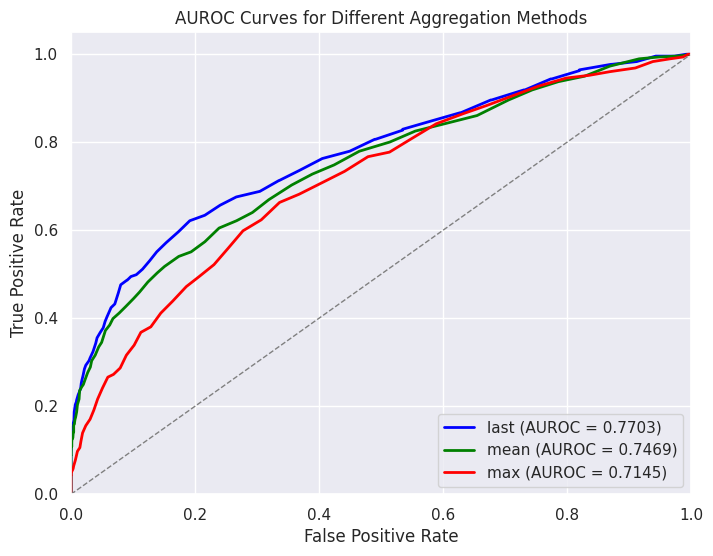


AUROC Summary:
last: 0.7703
mean: 0.7469
max: 0.7145


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

aggregation_methods = ['last', 'mean', 'max']

auroc_scores = {}
roc_curves = {}

rf_model = RandomForestClassifier(n_estimators=100, random_state=400)

for agg_method in aggregation_methods:
    print(f"\nProcessing aggregation method: {agg_method}")

    X_train, y_train = aggregate_admission_data(train_df, ehr_data["feat_dict"], agg_method)
    X_val, y_val = aggregate_admission_data(val_df, ehr_data["feat_dict"], agg_method)

    rf_model.fit(X_train, y_train)

    y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]
    auroc = roc_auc_score(y_val, y_val_pred_proba)
    auroc_scores[agg_method] = auroc

    fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
    roc_curves[agg_method] = (fpr, tpr)

    print(f"AUROC for {agg_method}: {auroc:.4f}")

plt.figure(figsize=(8, 6))
colors = {'last': 'blue', 'mean': 'green', 'max': 'red'}

for agg_method in aggregation_methods:
    fpr, tpr = roc_curves[agg_method]
    auroc = auroc_scores[agg_method]
    plt.plot(fpr, tpr, color=colors[agg_method], lw=2,
             label=f'{agg_method} (AUROC = {auroc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curves for Different Aggregation Methods')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

print("\nAUROC Summary:")
for agg_method in aggregation_methods:
    print(f"{agg_method}: {auroc_scores[agg_method]:.4f}")

Processing pre-processed data with 'last' method...
AUROC for pre-processed data: 0.7703

Processing filtered data with 'last' method...
AUROC for filtered data: 0.7645


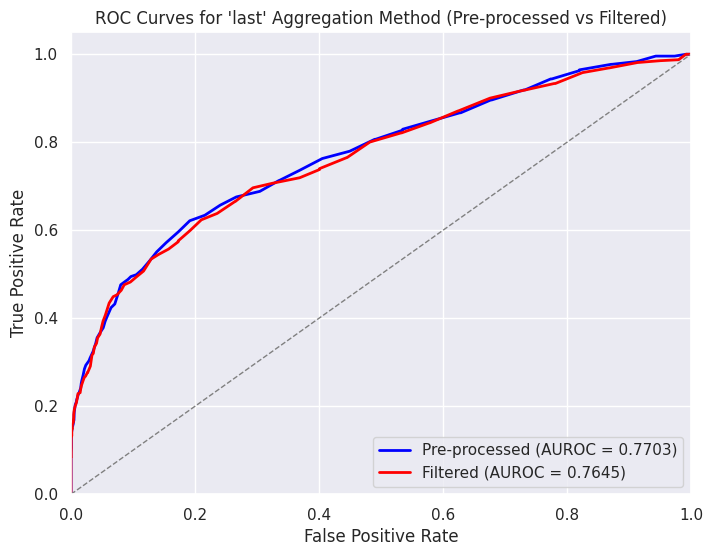


AUROC Summary:
Pre-processed data: 0.7703
Filtered data: 0.7645
Difference (Filtered - Pre-processed): -0.0058


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

aggregation_method = 'last'

auroc_scores = {}
roc_curves = {}

rf_model = RandomForestClassifier(n_estimators=100, random_state=400)

print("Processing pre-processed data with 'last' method...")
X_train, y_train = aggregate_admission_data(train_df, ehr_data["feat_dict"], aggregation_method)
X_val, y_val = aggregate_admission_data(val_df, ehr_data["feat_dict"], aggregation_method)

rf_model.fit(X_train, y_train)

y_val_pred_proba_before = rf_model.predict_proba(X_val)[:, 1]
auroc_before = roc_auc_score(y_val, y_val_pred_proba_before)
auroc_scores['Pre-processed'] = auroc_before

fpr_before, tpr_before, _ = roc_curve(y_val, y_val_pred_proba_before)
roc_curves['Pre-processed'] = (fpr_before, tpr_before)

print(f"AUROC for pre-processed data: {auroc_before:.4f}")

print("\nProcessing filtered data with 'last' method...")
X_train_filtered, y_train = aggregate_admission_data(train_df, ehr_data["feat_dict"], aggregation_method)
X_val_filtered, y_val = aggregate_admission_data(val_df, ehr_data["feat_dict"], aggregation_method)

X_train_filtered = np.delete(X_train_filtered, remove_indices, axis=1)
X_val_filtered = np.delete(X_val_filtered, remove_indices, axis=1)

rf_model.fit(X_train_filtered, y_train)

y_val_pred_proba_after = rf_model.predict_proba(X_val_filtered)[:, 1]
auroc_after = roc_auc_score(y_val, y_val_pred_proba_after)
auroc_scores['Filtered'] = auroc_after

fpr_after, tpr_after, _ = roc_curve(y_val, y_val_pred_proba_after)
roc_curves['Filtered'] = (fpr_after, tpr_after)

print(f"AUROC for filtered data: {auroc_after:.4f}")

plt.figure(figsize=(8, 6))
colors = {'Pre-processed': 'blue', 'Filtered': 'red'}

for data_type in ['Pre-processed', 'Filtered']:
    fpr, tpr = roc_curves[data_type]
    auroc = auroc_scores[data_type]
    plt.plot(fpr, tpr, color=colors[data_type], lw=2,
             label=f'{data_type} (AUROC = {auroc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves for 'last' Aggregation Method (Pre-processed vs Filtered)")
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

print("\nAUROC Summary:")
print(f"Pre-processed data: {auroc_scores['Pre-processed']:.4f}")
print(f"Filtered data: {auroc_scores['Filtered']:.4f}")
print(f"Difference (Filtered - Pre-processed): {(auroc_scores['Filtered'] - auroc_scores['Pre-processed']):.4f}")

Data before processing with 'last' method...
AUROC for data before processing: 0.7703

Data after processing with 'last' method...
AUROC for data after processing: 0.7645


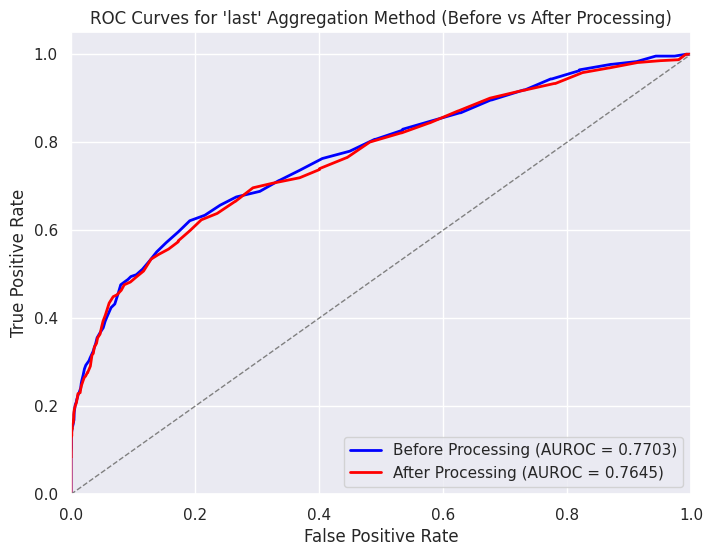


AUROC Summary:
Before Processing: 0.7703
After Processing: 0.7645
Difference (After - Before): -0.0058


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

aggregation_method = 'last'

auroc_scores = {}
roc_curves = {}

rf_model = RandomForestClassifier(n_estimators=100, random_state=400)

print("Data before processing with 'last' method...")
X_train, y_train = aggregate_admission_data(train_df, ehr_data["feat_dict"], aggregation_method)
X_val, y_val = aggregate_admission_data(val_df, ehr_data["feat_dict"], aggregation_method)

rf_model.fit(X_train, y_train)

y_val_pred_proba_before = rf_model.predict_proba(X_val)[:, 1]
auroc_before = roc_auc_score(y_val, y_val_pred_proba_before)
auroc_scores['Before Processing'] = auroc_before

fpr_before, tpr_before, _ = roc_curve(y_val, y_val_pred_proba_before)
roc_curves['Before Processing'] = (fpr_before, tpr_before)

print(f"AUROC for data before processing: {auroc_before:.4f}")

print("\nData after processing with 'last' method...")
X_train_filtered, y_train = aggregate_admission_data(train_df, ehr_data["feat_dict"], aggregation_method)
X_val_filtered, y_val = aggregate_admission_data(val_df, ehr_data["feat_dict"], aggregation_method)

X_train_filtered = np.delete(X_train_filtered, remove_indices, axis=1)
X_val_filtered = np.delete(X_val_filtered, remove_indices, axis=1)

rf_model.fit(X_train_filtered, y_train)

y_val_pred_proba_after = rf_model.predict_proba(X_val_filtered)[:, 1]
auroc_after = roc_auc_score(y_val, y_val_pred_proba_after)
auroc_scores['After Processing'] = auroc_after

fpr_after, tpr_after, _ = roc_curve(y_val, y_val_pred_proba_after)
roc_curves['After Processing'] = (fpr_after, tpr_after)

print(f"AUROC for data after processing: {auroc_after:.4f}")

plt.figure(figsize=(8, 6))
colors = {'Before Processing': 'blue', 'After Processing': 'red'}

for data_type in ['Before Processing', 'After Processing']:
    fpr, tpr = roc_curves[data_type]
    auroc = auroc_scores[data_type]
    plt.plot(fpr, tpr, color=colors[data_type], lw=2,
             label=f'{data_type} (AUROC = {auroc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves for 'last' Aggregation Method (Before vs After Processing)")
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

print("\nAUROC Summary:")
print(f"Before Processing: {auroc_scores['Before Processing']:.4f}")
print(f"After Processing: {auroc_scores['After Processing']:.4f}")
print(f"Difference (After - Before): {(auroc_scores['After Processing'] - auroc_scores['Before Processing']):.4f}")

Processing data without balancing (no class_weight)...
AUROC without balancing: 0.7703

Processing data with balancing (class_weight='balanced')...
AUROC with balancing: 0.7695


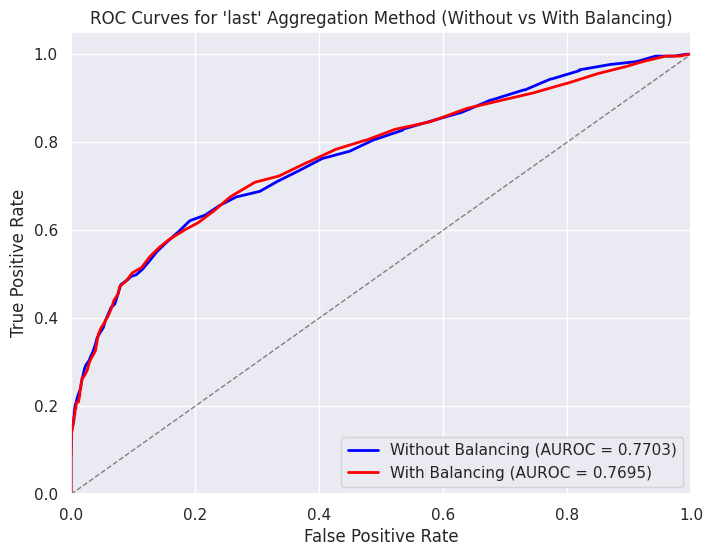


AUROC Summary:
Without balancing: 0.7703
With Balancing: 0.7695
Difference (With - Without): -0.0007

Label distribution in training set:
False    0.824022
True     0.175978
Name: proportion, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

aggregation_method = 'last'

auroc_scores = {}
roc_curves = {}

print("Processing data without balancing (no class_weight)...")
X_train, y_train = aggregate_admission_data(train_df, ehr_data["feat_dict"], aggregation_method)
X_val, y_val = aggregate_admission_data(val_df, ehr_data["feat_dict"], aggregation_method)

rf_model = RandomForestClassifier(n_estimators=100, random_state=400)
rf_model.fit(X_train, y_train)

y_val_pred_proba_before = rf_model.predict_proba(X_val)[:, 1]
auroc_before = roc_auc_score(y_val, y_val_pred_proba_before)
auroc_scores['Without Balancing'] = auroc_before

fpr_before, tpr_before, _ = roc_curve(y_val, y_val_pred_proba_before)
roc_curves['Without Balancing'] = (fpr_before, tpr_before)

print(f"AUROC without balancing: {auroc_before:.4f}")


print("\nProcessing data with balancing (class_weight='balanced')...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=400, class_weight='balanced')
rf_model.fit(X_train, y_train)

y_val_pred_proba_after = rf_model.predict_proba(X_val)[:, 1]
auroc_after = roc_auc_score(y_val, y_val_pred_proba_after)
auroc_scores['With Balancing'] = auroc_after

fpr_after, tpr_after, _ = roc_curve(y_val, y_val_pred_proba_after)
roc_curves['With Balancing'] = (fpr_after, tpr_after)

print(f"AUROC with balancing: {auroc_after:.4f}")

plt.figure(figsize=(8, 6))
colors = {'Without Balancing': 'blue', 'With Balancing': 'red'}

for data_type in ['Without Balancing', 'With Balancing']:
    fpr, tpr = roc_curves[data_type]
    auroc = auroc_scores[data_type]
    plt.plot(fpr, tpr, color=colors[data_type], lw=2,
             label=f'{data_type} (AUROC = {auroc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves for 'last' Aggregation Method (Without vs With Balancing)")
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

print("\nAUROC Summary:")
print(f"Without balancing: {auroc_scores['Without Balancing']:.4f}")
print(f"With Balancing: {auroc_scores['With Balancing']:.4f}")
print(f"Difference (With - Without): {(auroc_scores['With Balancing'] - auroc_scores['Without Balancing']):.4f}")

print("\nLabel distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))